### **E-Commerce Product Recommendation Engine using Graph DB and PySpark**


#### **Contents**

1. Reading CSV data - Department, Category, Products, Customer, Order, Items
2. Data Processing and Transformation
3. K-Means Clustering for Customer Segmentation
4. Exploratory Data Analysis using SparkSQL
5. Writing CSV data to Neo4j Sandbox. Incorporting Cluster data to GraphDB
6. Building Product Recommendation using Graph DB



**1. Initializing PySpark and reading CSV data**

In [27]:
#Install PySpark that is compatible with Neo4j and ML processing
#!pip install pyspark==3.0.3
!pip install pyspark==3.0.1

In [ ]:
!python --version

Python 3.10.12


In [ ]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder.appName('MachineLearning').getOrCreate())

In [ ]:
spark.version

'3.0.1'

**1.1 Loading CSV data**

In [12]:
product = spark.read.csv('products.csv',inferSchema=True,header=True)
category = spark.read.csv('categories.csv',inferSchema=True,header=True)
customer = spark.read.csv('customers.csv',inferSchema=True,header=True)
department = spark.read.csv('departments.csv',inferSchema=True,header=True)
order = spark.read.csv('orders.csv',inferSchema=True,header=True)
item = spark.read.csv('order_items.csv',inferSchema=True,header=True)

In [ ]:
department.show(2)
category.show(2)
product.show(2)
order.show(2)
item.show(2)
customer.show(2)

+-------+---------+
|dept_id|dept_name|
+-------+---------+
|      2|  Fitness|
|      3| Footwear|
+-------+---------+
only showing top 2 rows

+-----------+----------------+-------------+
|category_id|category_dept_id|category_name|
+-----------+----------------+-------------+
|          1|               2|     Football|
|          2|               2|       Soccer|
+-----------+----------------+-------------+
only showing top 2 rows

+----------+-------------------+--------------------+-------------+--------------------+
|product_id|product_category_id|        product_name|product_price|   product_image_url|
+----------+-------------------+--------------------+-------------+--------------------+
|         1|                  2|Quest Q64 10 FT. ...|        59.98|http://images.acm...|
|         2|                  2|Under Armour Men'...|       129.99|http://images.acm...|
+----------+-------------------+--------------------+-------------+--------------------+
only showing top 2 rows

+

In [ ]:
# import utility functions that we'll use in the notebook
from pyspark.sql.types import *
from pyspark.sql.functions import *

#### **2. Data Processing and Transformation**

In [ ]:
final_df = category.join(department,category.category_dept_id == department.dept_id, "inner") \
                  .join(product, category.category_id == product.product_category_id, "left") \
                  .join(item, product.product_id == item.item_product_id, "left") \
                  .join(order, item.item_order_id == order.order_id, "right") \
                  .join(customer, order.order_customer_id == customer.customer_id, "outer")


In [ ]:
col_names = ['category_id','category_name','dept_id','dept_name','product_id',
             'product_name','product_price','item_id','item_quantity','item_subtotal','order_id','order_date',
             'order_status','customer_id','customer_fname','customer_lname','customer_street','customer_city','customer_state','customer_zip']

final_df = final_df.select(*col_names)

final_df.show(10)

+-----------+--------------------+-------+---------+----------+--------------------+-------------+-------+-------------+-------------+--------+----------+------------+-----------+--------------+--------------+----------------+-------------+--------------+------------+
|category_id|       category_name|dept_id|dept_name|product_id|        product_name|product_price|item_id|item_quantity|item_subtotal|order_id|order_date|order_status|customer_id|customer_fname|customer_lname| customer_street|customer_city|customer_state|customer_zip|
+-----------+--------------------+-------+---------+----------+--------------------+-------------+-------+-------------+-------------+--------+----------+------------+-----------+--------------+--------------+----------------+-------------+--------------+------------+
|         24|     Women's Apparel|      5|     Golf|       502|Nike Men's Dri-FI...|         50.0| 152888|            3|        150.0|   61124| 12/2/2013|      CLOSED|        148|     Stephanie

In [ ]:
final_df.describe().show()

+-------+------------------+------------------+------------------+---------+------------------+--------------------+------------------+-----------------+------------------+------------------+-----------------+----------+---------------+------------------+--------------+--------------+--------------------+-------------+--------------+-----------------+
|summary|       category_id|     category_name|           dept_id|dept_name|        product_id|        product_name|     product_price|          item_id|     item_quantity|     item_subtotal|         order_id|order_date|   order_status|       customer_id|customer_fname|customer_lname|     customer_street|customer_city|customer_state|     customer_zip|
+-------+------------------+------------------+------------------+---------+------------------+--------------------+------------------+-----------------+------------------+------------------+-----------------+----------+---------------+------------------+--------------+--------------+-------

In [ ]:
#Dropping Null values from customers who didnt place any order for model training

final_df1 = final_df.na.drop()


#### **3. Customer Segmentation using K-Means Cluster technique**

---



In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans

# Step 1: Encode categorical features using StringIndexer + OneHotEncoder
categoricalColumns = ['dept_name', 'order_status', 'customer_state', 'category_id']
indexOutputCols = [x + "_Index" for x in categoricalColumns]
oheOutputCols = [x + "_OHE" for x in categoricalColumns]

stringIndexer = StringIndexer(inputCols=categoricalColumns, outputCols=indexOutputCols)
oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputCols)

# Step 2: Assemble all feature columns (numerical + categorical) into a single feature vector
numericalCols = ['product_price', 'item_quantity']
assemblerInputs = oheOutputCols + numericalCols
vectorAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Step 3: Define the pipeline
pipeline = Pipeline(stages=[stringIndexer, oheEncoder, vectorAssembler])

# Assume final_df1 is your initial Spark DataFrame
pipelineModel = pipeline.fit(final_df1)
dataset = pipelineModel.transform(final_df1)


In [ ]:
# Model fitting and prediction
k = 5

kmeans = KMeans(featuresCol="features", k=k, seed=1)
model = kmeans.fit(dataset)

# Make predictions (each customer assigned to a cluster)
predictions = model.transform(dataset)

# Optional: Evaluate clustering by computing Silhouette score
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.6927063415112292


Silhouette score of approximately **0.69** suggests that, on average, objects are relatively well clustered. This is a relatively high score, indicating that the data points are, on average, closer to other data points in their cluster than to data points in other clusters. This implies that the **K-Means model is good** and grouped the data into clusters that are compact and well-separated from each other.

In [ ]:
# Select customer_id and its assigned cluster
cluster_assignments = predictions.select("customer_id", "prediction")

cluster_assignments.show(5)

+-----------+----------+
|customer_id|prediction|
+-----------+----------+
|        148|         1|
|        148|         0|
|        148|         1|
|        148|         0|
|        148|         1|
+-----------+----------+
only showing top 5 rows



Since the model/predictions were made at transcational level, each customer is associated with multiple cluster according to their order behavior. We will assign customer to the cluster that they are associated most with

In [ ]:
from pyspark.sql import Window
import pyspark.sql.functions as F

# Group by customer_id and prediction, then counting the occurrences
prediction_counts = cluster_assignments.groupBy('customer_id', 'prediction')\
                                   .agg(F.count('prediction').alias('count'))

# Window partitioned by customer_id and ordered by count in descending order
windowSpec = Window.partitionBy('customer_id').orderBy(F.desc('count'))

# Using row_number window function to assign a unique row number to each row within the partition of customer_id
ranked_predictions = prediction_counts.withColumn('rank', F.row_number().over(windowSpec))

# Filtering to get only the top row (highest count or rank = 1) for each customer_id
cluster = ranked_predictions.filter(ranked_predictions['rank'] == 1)\
                                                .drop('rank', 'count')

cluster.show(5)


+-----------+----------+
|customer_id|prediction|
+-----------+----------+
|        148|         1|
|        463|         1|
|        471|         4|
|        496|         1|
|        833|         0|
+-----------+----------+
only showing top 5 rows



In [ ]:
# Saving the cluster data as csv
output_path = "/content/cluster.csv"

# Save the DataFrame to CSV
cluster.coalesce(1).write.csv(output_path, mode="overwrite", header=True)

In [ ]:
cluster.show(5)

+-----------+----------+
|customer_id|prediction|
+-----------+----------+
|        148|         1|
|        463|         1|
|        471|         4|
|        496|         1|
|        833|         0|
+-----------+----------+
only showing top 5 rows



### 4. **EDA using SparkSQL**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext, Row

if __name__ == "__main__":
    session = SparkSession.builder.enableHiveSupport().getOrCreate()
    sc = session.sparkContext
    hiveCtx = HiveContext(sc)

In [ ]:
import pandas as pd

categories = pd.read_csv("categories.csv")
df_categories = hiveCtx.createDataFrame(categories)
df_categories.createOrReplaceTempView("categories")

customers = pd.read_csv("customers.csv")
df_customers = hiveCtx.createDataFrame(customers)
df_customers.createOrReplaceTempView("customers")

departments = pd.read_csv("departments.csv")
df_departments = hiveCtx.createDataFrame(departments)
df_departments.createOrReplaceTempView("departments")

order_items = pd.read_csv("order_items.csv")
df_order_items = hiveCtx.createDataFrame(order_items)
df_order_items.createOrReplaceTempView("order_items")

orders = pd.read_csv("orders.csv")
df_orders = hiveCtx.createDataFrame(orders)
df_orders.createOrReplaceTempView("orders")

products = pd.read_csv("products.csv")
df_products = hiveCtx.createDataFrame(products)
df_products.createOrReplaceTempView("products")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and wil

**4.1  Customer Churn Rate**

In [ ]:
# Calculate total number of customers
total_customers_analysis = hiveCtx.sql("""
    SELECT COUNT(*) AS total_customers_count
    FROM customers
""").collect()[0][0]

# Calculate churned customers count
churned_customers_analysis = hiveCtx.sql("""
    SELECT COUNT(*) AS churned_customers_count
    FROM customers
    WHERE customer_id NOT IN (
        SELECT DISTINCT order_customer_id
        FROM orders
    )
""").collect()[0][0]

# Calculate churn rate as a percentage
churn_rate_percentage = (churned_customers_analysis / total_customers_analysis) * 100

# Display results
print("Total customers:", total_customers_analysis)
print("Churned customers:", churned_customers_analysis)
print("Churn rate (%):", churn_rate_percentage)


Total customers: 12435
Churned customers: 30
Churn rate (%): 0.24125452352231602


**4.2 Average Order Value of each Customer**

In [ ]:
average_order_value_per_customer = hiveCtx.sql("""
    SELECT o.order_customer_id, AVG(oi.item_subtotal) AS average_order_value
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.item_order_id
    GROUP BY o.order_customer_id
    ORDER BY average_order_value DESC
""")

average_order_value_per_customer.show()

+-----------------+-------------------+
|order_customer_id|average_order_value|
+-----------------+-------------------+
|             6164|             499.95|
|                1|             499.95|
|             9385| 449.96500000000003|
|            10904| 433.30333333333334|
|             6207|             399.98|
|             8985|             399.98|
|             3312|             399.98|
|             1230|             399.98|
|              992|             399.98|
|             2396|             399.98|
|             4828|             399.98|
|             3698|             399.98|
|             3662|             399.98|
|             4146|  399.9766666666667|
|             6324|             399.97|
|             9983| 399.96500000000003|
|             7372|             399.96|
|             4826|             399.96|
|             4844|  391.6466666666667|
|             6517|            383.982|
+-----------------+-------------------+
only showing top 20 rows



**4.3 Customers with repeat orders**

In [ ]:
repeat_customers_across_categories = hiveCtx.sql("""
    SELECT o.order_customer_id,p.product_id,p.product_name,count(o.order_date)
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.item_order_id
    JOIN products p ON oi.item_product_id = p.product_id
    GROUP BY o.order_customer_id,p.product_id,p.product_name, o.order_date, o.order_status
    HAVING COUNT(DISTINCT o.order_id) > 1 AND o.order_status NOT IN ('CANCELED','SUSPECTED_FRAUD')
    ORDER BY 4 DESC
""")

# Show the result for repeat customers across different product categories
repeat_customers_across_categories.show(truncate=False)

+-----------------+----------+-----------------------------------------+-----------------+
|order_customer_id|product_id|product_name                             |count(order_date)|
+-----------------+----------+-----------------------------------------+-----------------+
|8038             |502       |Nike Men's Dri-FIT Victory Golf Polo     |4                |
|6465             |1014      |O'Brien Men's Neoprene Life Vest         |3                |
|8674             |403       |Nike Men's CJ Elite 2 TD Football Cleat  |3                |
|7183             |1014      |O'Brien Men's Neoprene Life Vest         |3                |
|9952             |1014      |O'Brien Men's Neoprene Life Vest         |3                |
|8638             |365       |Perfect Fitness Perfect Rip Deck         |3                |
|10377            |502       |Nike Men's Dri-FIT Victory Golf Polo     |3                |
|8038             |403       |Nike Men's CJ Elite 2 TD Football Cleat  |3                |

**4.4 Customer Life-Time Value Analysis**

In [ ]:
# Calculate the lifetime value of repeat customers
lifetime_value_analysis = hiveCtx.sql("""
    SELECT o.order_customer_id, COUNT(o.order_id) AS total_orders, SUM(oi.item_subtotal) AS total_spent
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.item_order_id
    WHERE o.order_customer_id IN (
        SELECT order_customer_id
        FROM (
                SELECT o.order_customer_id,p.product_id,p.product_name,count(o.order_date)
                FROM orders o
                JOIN order_items oi ON o.order_id = oi.item_order_id
                JOIN products p ON oi.item_product_id = p.product_id
                GROUP BY o.order_customer_id,p.product_id,p.product_name, o.order_date, o.order_status
                HAVING COUNT(DISTINCT o.order_id) > 1 AND o.order_status NOT IN ('CANCELED','SUSPECTED_FRAUD')
                ORDER BY 4 DESC
        ) AS repeat_customers
    )
    GROUP BY o.order_customer_id
    ORDER BY total_spent DESC
""")

# Show the result for the lifetime value analysis of repeat customers
lifetime_value_analysis.show(truncate=False)

+-----------------+------------+------------------+
|order_customer_id|total_orders|total_spent       |
+-----------------+------------+------------------+
|10351            |28          |8339.26           |
|6615             |35          |7179.1900000000005|
|172              |32          |6591.23           |
|9107             |33          |6129.199999999999 |
|688              |24          |5909.24           |
|1169             |29          |5613.2300000000005|
|548              |28          |5458.34           |
|744              |27          |5339.32           |
|10543            |26          |5311.43           |
|10521            |23          |5249.52           |
|9459             |30          |5238.43           |
|2609             |25          |5159.46           |
|3531             |29          |5140.410000000001 |
|8757             |29          |5051.26           |
|11761            |29          |5049.349999999999 |
|2618             |25          |4757.39           |
|8674       

Based on above analysis, we can improve our recommendation, and make real-time recommendation faster with Graph DB

### **5. Writing data from Spark to Neo4j Sandbox**

In [28]:
#Connection to Neo4j Sanbox (Online Graph DB) - credentials, URL of Neo4j Sandbox DB

neo4j_url = "bolt://54.208.99.244:7687"
neo4j_user = "neo4j"
neo4j_password = "trip-top-machinery"
#neo4j_url = "bolt://localhost:7687"  #if connecting to Neo4j Desktop

In [29]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [30]:
# install spark (change the version number if needed)

!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz

In [31]:
# unzip the spark file to the current folder
!tar xf spark-3.0.1-bin-hadoop3.2.tgz

In [32]:
# setting spark folder to system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

In [33]:
# install findspark using pip
!pip install -q findspark

In [34]:
import findspark
findspark.init()

In [35]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
        .master('local[*]')
        .appName('Project')
        .config('spark.executor.memory', '4g')  # Allocate memory to Spark executor, e.g., 4g for 4GB
        .config('spark.executor.cores', '4')  # Number of cores for each executor
        .config('spark.cores.max', '4')  # Maximum number of cores to use
        .config('spark.driver.memory','4g')  # Memory for Spark driver, e.g., 4g for 4GB
        .config('spark.ui.port', '4050')
        .config('spark.jars.packages', 'org.neo4j:neo4j-connector-apache-spark_2.12:4.1.5_for_spark_3')
        .config("spark.jars", "/path/to/neo4j-spark-connector_2.12-4.1.5.jar")
        .config("neo4j.url", neo4j_url)
        .config("neo4j.authentication.type", "basic")
        .config("neo4j.authentication.basic.username", neo4j_user)
        .config("neo4j.authentication.basic.password", neo4j_password)
        .getOrCreate())

In [11]:
spark.version

'3.0.1'

**5.1 Writing Nodes to Neo4j Sandbox**

In [ ]:
(product
  .write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("labels", "Product")
  .option('schema.optimization.type', 'NODE_CONSTRAINTS')
  .option('partitions','4')
  .option("node.keys", "product_id")
  .save())

(category
  .write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("labels", "Category")
  .option('schema.optimization.type', 'NODE_CONSTRAINTS')
  .option('partitions','4')
  .option("node.keys", "category_id")
  .save())


(department
  .write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("labels", "Department")
  .option('schema.optimization.type', 'NODE_CONSTRAINTS')
  .option('partitions','4')
  .option("node.keys", "dept_id")
  .save())


(customer
  .write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("labels", "Customer")
  .option('schema.optimization.type', 'NODE_CONSTRAINTS')
  .option('partitions','4')
  .option("node.keys", "customer_id")
  .save())

(order
  .write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("labels", "Order")
  .option('schema.optimization.type', 'NODE_CONSTRAINTS')
  .option('partitions','4')
  .option("node.keys", "order_id")
  .save())


(item
  .write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("labels", "Item")
  .option('schema.optimization.type', 'NODE_CONSTRAINTS')
  .option('partitions','4')
  .option("node.keys", "item_id")
  .save())


(cluster
  .write
  .format("org.neo4j.spark.DataSource")
  .mode("Overwrite")
  .option("labels", "Cluster")
  .option('schema.optimization.type', 'NODE_CONSTRAINTS')
  .option('partitions','4')
  .option("node.keys", "customer_id")
  .save())

**5.2 Writing relationship**

In [ ]:
(product.write.format('org.neo4j.spark.DataSource')
        .mode('Overwrite')
        .option("neo4j.url", neo4j_url)
        .option("neo4j.authentication.type", "basic")
        .option("neo4j.authentication.basic.username", neo4j_user)
        .option("neo4j.authentication.basic.password", neo4j_password)
        .option('query','MATCH (p:Product), (c:Category) WHERE p.product_category_id = c.category_id MERGE (p)-[:BELONGS_TO]->(c)')
        .save())


(category.write.format('org.neo4j.spark.DataSource')
        .mode('Overwrite')
        .option("neo4j.url", neo4j_url)
        .option("neo4j.authentication.type", "basic")
        .option("neo4j.authentication.basic.username", neo4j_user)
        .option("neo4j.authentication.basic.password", neo4j_password)
        .option('query','MATCH (d:Department), (c:Category) WHERE d.dept_id = c.category_dept_id MERGE (d)-[:HAS]->(c)')
        .save())


(order.write.format('org.neo4j.spark.DataSource')
        .mode('Overwrite')
        .option("neo4j.url", neo4j_url)
        .option("neo4j.authentication.type", "basic")
        .option("neo4j.authentication.basic.username", neo4j_user)
        .option("neo4j.authentication.basic.password", neo4j_password)
        .option('query','MATCH (c:Customer), (o:Order) WHERE d.customer_id = c.customer_id MERGE (c)-[:ORDERED]->(d)')
        .save())

(item.write.format('org.neo4j.spark.DataSource')
        .mode('Overwrite')
        .option("neo4j.url", neo4j_url)
        .option("neo4j.authentication.type", "basic")
        .option("neo4j.authentication.basic.username", neo4j_user)
        .option("neo4j.authentication.basic.password", neo4j_password)
        .option('query','MATCH (p:Product), (i:Item) WHERE p.product_id = i.product_id MERGE (p)-[:HAS_QTY]->(i)')
        .save())

(item.write.format('org.neo4j.spark.DataSource')
        .mode('Overwrite')
        .option("neo4j.url", neo4j_url)
        .option("neo4j.authentication.type", "basic")
        .option("neo4j.authentication.basic.username", neo4j_user)
        .option("neo4j.authentication.basic.password", neo4j_password)
        .option('query','MATCH (o:Order), (i:Item) WHERE o.order_id = i.order_id MERGE (o)-[:HAS_ITEMS]->(i)')
        .save())

(cluster.write.format('org.neo4j.spark.DataSource')
        .mode('Overwrite')
        .option("neo4j.url", neo4j_url)
        .option("neo4j.authentication.type", "basic")
        .option("neo4j.authentication.basic.username", neo4j_user)
        .option("neo4j.authentication.basic.password", neo4j_password)
        .option('query','MATCH (c:Customer), (r:Cluster) WHERE c.customer_id = r.cluster_customer_id MERGE (c)-[:IN_CLUSTER]->(r)')
        .save())

**5.3 Neo4j DB Schema**

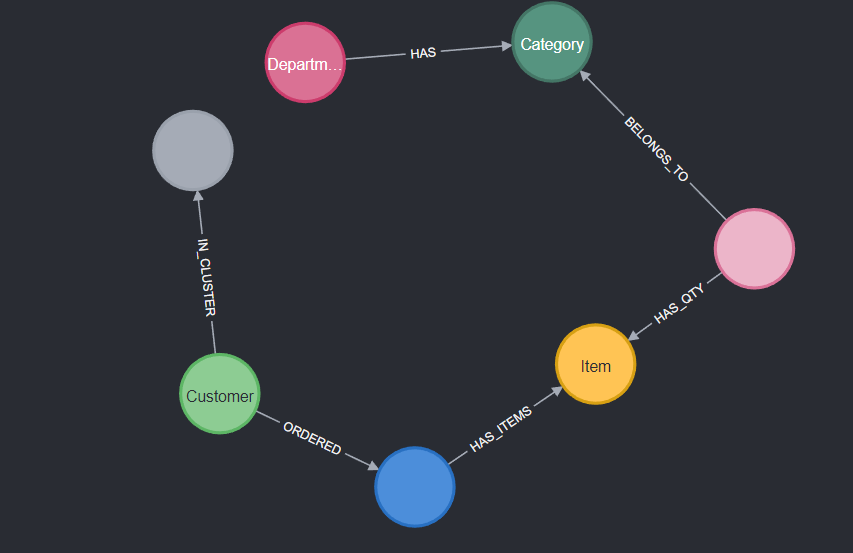

1. Customer-[:IN_CLUSTER]->Cluster
2. Customer-[:ORDERED]-> Order
3. Order-[:HAS_ITEMS]->Item
4. Product-[:HAS_QTY]->Item
5. Product-[:BELONGS_TO]->Category
6. Department-[:HAS]->Category

6 nodes and 5 relationships






#### **6. Product Recommendation**

In [36]:
!pip install neo4j-driver
!pip install py2neo
from py2neo import Graph

In [24]:
graph = Graph(neo4j_url,auth=(neo4j_user,neo4j_password))
graph

Graph('bolt://54.208.99.244:7687')

#### **6.1 Business Problems**
**1. Recommend products from the most popular category within the customer's cluster**

In [22]:
query = """
// Identify the customer's cluster and the most popular category within that cluster
MATCH (c:Customer)-[:IN_CLUSTER]->(cl:Cluster)
WHERE
MATCH (cl)<-[:IN_CLUSTER]-(c2:Customer)
MATCH (c2)-[:ORDERED]->(o:Order)
MATCH (o)-[:HAS_ITEMS]->(i:Item)
MATCH (i)<-[:HAS_QTY]-(p:Product)
MATCH (p)-[:BELONGS_TO]->(cat:Category)
WITH cl.cluster AS cluster_grp,cat.category_id AS cat_id, count(p) AS purchases
ORDER BY purchases DESC
LIMIT 1


// With the most popular category identified, recommend the most popular products within this category
MATCH (cat1:Category)<-[:BELONGS_TO]-(p:Product)
WHERE toInteger(cat1.category_id) = toInteger(cat_id)
MATCH (p)-[:HAS_QTY]->(i:Item)
MATCH (i)<-[:HAS_ITEMS]-(o:Order)
RETURN cluster_grp,p.product_id, p.product_name, COUNT(o) AS orders
ORDER BY orders DESC
LIMIT 10

"""
print('Cluster  | Product ID |  Product_Name |  Orders')
# Execute the query
nodes = graph.run(query)

# Iterate through the results
for node in nodes:
    print(node)

Cluster  | Product ID |  Product_Name |  Orders
1	'365'	'Perfect Fitness Perfect Rip Deck'	20170
1	'364'	'Total Gym 1400'	36


**2. Recommend products that are commonly bought together with the customer (ID-10351) last purchase**

In [37]:
query = """
MATCH (cl:Cluster)<-[:IN_Cluster]-(c:Customer {customer_id:'10351})
MATCH (c)-[:ORDERED]->(o)
MATCH (o)-[:HAS_ITEMS]->(i)
MATCH (i)<-[:HAS_QTY]-(p:Product)
WITH cl.cluster AS clustgrp,c.customer_id AS custid, collect(p.product_id) AS custprods

//Recommend based on what other customers in same cluster bought togther with the product 10351 bought
MATCH (cl2:Cluster)-[:IN_CLUSTER]-(other:Customer)
WHERE cl2.cluser = clustgrp
MATCH (other)-[:ORDERED]->(o2)
MATCH (o2)-[:HAS_ITEMS]->(i2)
MATCH (i2)<-[:HAS_QTY]-(p2:Product)
WHERE other.customer_id <> custid AND NOT p2.product_id IN custprods AND o2.order_status<>'CANCELED'
RETURN p2.product_name, COUNT(*) AS count
ORDER BY count DESC
LIMIT 5

"""
print('Product_Name | Orders')
nodes = graph.run(query)
for node in nodes:
    print(node)

Product_Name | Orders
"Nike Men's CJ Elite 2 TD Football Cleat"	8706
"Nike Men's Dri-FIT Victory Golf Polo"	8388
"O'Brien Men's Neoprene Life Vest"	7725
'Field & Stream Sportsman 16 Gun Fire Safe'	6868
'Pelican Sunstream 100 Kayak'	6161


#### **6. References**



1.   https://neo4j.com/docs/spark/current/overview/
2.   https://www.youtube.com/watch?v=oMTmG4ClO5I
3.   https://www.youtube.com/watch?v=581Zd-Yihew
4. https://sandbox.neo4j.com/?usecase=fraud-detection
5.   https://community.neo4j.com/t/fastest-way-to-load-data-in-neo4j-using-python/35904/6
6. https://community.cloudera.com/t5/Community-Articles/Spark-Python-Supportability-Matrix/ta-p/379144
7. https://github.com/neo4j-contrib/neo4j-spark-connector


